In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Swiler's file paths for each dataset. 
gdp_data = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/GDP.csv', parse_dates=['DATE'])
cpat_tax = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/CPATAX.csv', parse_dates=['DATE'])
durable_goods = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/manufacturers_new_orders_durable_goods_excluding_defense.csv', parse_dates=['DATE'])
housing_starts = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/housing start.csv', parse_dates=['DATE'])
industrial_production = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/industrial_production_total_index.csv', parse_dates=['DATE'])
personal_consumption = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/PCECTPI.csv', parse_dates=['DATE'])
t10y2y = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/T10Y2Y.csv', parse_dates=['DATE'])
sp500_vix = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/sp500_vix_quarterly.csv', parse_dates=['Date'])
gtrend_recession = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/gtrend_recession.csv', parse_dates=['Month'])
gtrend_unemployment = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/gtrend_unemployment.csv', parse_dates=['Month'])
nonderiv_insider_activity = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/nonderiv_insider_activity.csv', parse_dates=['transactionDate'])

In [3]:
# Merge datasets on their respective date columns
data = gdp_data.copy()  # Start with GDP data

# Merge other datasets using 'DATE' or appropriate columns
data = data.merge(cpat_tax, on='DATE', how='left')
data = data.merge(durable_goods, on='DATE', how='left')
data = data.merge(housing_starts, on='DATE', how='left')
data = data.merge(industrial_production, on='DATE', how='left')
data = data.merge(personal_consumption, on='DATE', how='left')
data = data.merge(t10y2y, on='DATE', how='left')
data = data.merge(sp500_vix.rename(columns={'Date': 'DATE'}), on='DATE', how='left')
data = data.merge(gtrend_recession.rename(columns={'Month': 'DATE'}), on='DATE', how='left')
data = data.merge(gtrend_unemployment.rename(columns={'Month': 'DATE'}), on='DATE', how='left')
data = data.merge(nonderiv_insider_activity.rename(columns={'transactionDate': 'DATE'}), on='DATE', how='left')

Best parameters for Model 1: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best Accuracy score for Model 1: 0.9282474600870827

Random Forest Model 1 Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.97        84
         1.0       0.00      0.00      0.00         6

    accuracy                           0.93        90
   macro avg       0.47      0.50      0.48        90
weighted avg       0.87      0.93      0.90        90



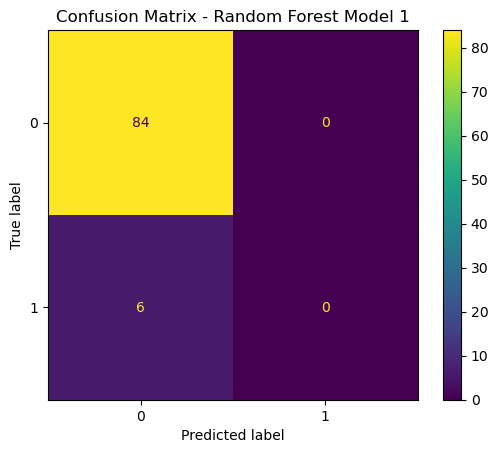

Model 1 likelihood of recession in Q1 2022: 1.00%


In [7]:
#Model 1 - lots of data, less variables. 2022Q1 Prediction.
# Ensure 'DATE' is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 1: Define training data to include all data up to Q4 2021
train_data = data[data['DATE'] < '2022-01-01'].copy()

# Create target variable
train_data['GDP_diff'] = train_data['GDP'].diff()
train_data['Recession'] = np.where(train_data['GDP_diff'] < 0, 1, 0)
train_data['Recession_next_quarter'] = train_data['Recession'].shift(-1)

# Define Model 1 variables
X_model1 = train_data[['CPATAX', 'PCECTPI', 'IPB50001SQ']]
y = train_data['Recession_next_quarter']

# Concatenate features and target, then drop rows with missing values
Xy_model1 = pd.concat([X_model1, y], axis=1).dropna()
X_model1_cleaned = Xy_model1.drop(columns=['Recession_next_quarter'])
y_model1_cleaned = Xy_model1['Recession_next_quarter']

# Scale features
scaler = StandardScaler()
X_model1_scaled = scaler.fit_transform(X_model1_cleaned)

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_model1_scaled, y_model1_cleaned, test_size=0.3, random_state=42, stratify=y_model1_cleaned)

# Define parameter grid for grid search
param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

# Pipeline for scaling and RandomForest
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Run GridSearchCV for Model 1 using accuracy as the metric
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=4), 
                             scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train1, y_train1)
print("Best parameters for Model 1:", grid_search.best_params_)
print("Best Accuracy score for Model 1:", grid_search.best_score_)

# Train the best model on the full training set
best_rf_model1 = grid_search.best_estimator_
best_rf_model1.fit(X_train1, y_train1)

# Evaluate the model
y_pred_model1 = best_rf_model1.predict(X_test1)
print("\nRandom Forest Model 1 Report (Test Set):\n", classification_report(y_test1, y_pred_model1, zero_division=0))
cm_model1 = confusion_matrix(y_test1, y_pred_model1)
ConfusionMatrixDisplay(confusion_matrix=cm_model1).plot()
plt.title("Confusion Matrix - Random Forest Model 1")
plt.show()

# Step 2: Prepare Q1 2022 data for prediction
# Include the last row from Q4 2021 to calculate differencing for Q1 2022
test_data_q4_2021 = data[(data['DATE'] >= '2021-10-01') & (data['DATE'] < '2022-01-01')].copy()
last_row_q4_2021 = test_data_q4_2021.iloc[-1]

# Step 3: Calculate differenced features for Q1 2022
X_test_model1_2022 = pd.DataFrame([{
    'CPATAX': data[data['DATE'] == '2022-01-01']['CPATAX'].values[0] - last_row_q4_2021['CPATAX'],
    'PCECTPI': data[data['DATE'] == '2022-01-01']['PCECTPI'].values[0] - last_row_q4_2021['PCECTPI'],
    'IPB50001SQ': data[data['DATE'] == '2022-01-01']['IPB50001SQ'].values[0] - last_row_q4_2021['IPB50001SQ']
}])

# Step 4: Scale the test features using the scaler from training
X_test_model1_scaled = scaler.transform(X_test_model1_2022)

# Step 5: Make predictions for Q1 2022
y_pred_proba_model1_Q1_2022 = best_rf_model1.predict_proba(X_test_model1_scaled)[:, 1]  # Probability of class 1 (recession)

# Print the percentage likelihood of a recession for Q1 2022
print(f"Model 1 likelihood of recession in Q1 2022: {y_pred_proba_model1_Q1_2022[0] * 100:.2f}%")


Best parameters for Model 3: {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best Accuracy score for Model 3: 0.9599358974358975

Random Forest Model 3 Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        19
         1.0       1.00      0.50      0.67         2

    accuracy                           0.95        21
   macro avg       0.97      0.75      0.82        21
weighted avg       0.95      0.95      0.95        21



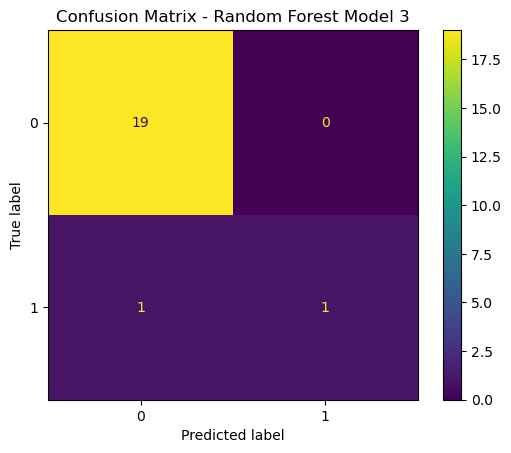

Prediction for recession in Q1 2022: 30.12% likelihood of recession


In [19]:
from sklearn.tree import export_text
#Model 3 - less data, more novel variables 2022Q1 Prediciton.
# Ensure 'DATE' is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 1: Define training data to include all data up to Q4 2021
train_data = data[data['DATE'] < '2022-01-01'].copy()

# Create target variable and differenced features within the training set
train_data['GDP_diff'] = train_data['GDP'].diff()
train_data['Recession'] = np.where(train_data['GDP_diff'] < 0, 1, 0)
train_data['Recession_next_quarter'] = train_data['Recession'].shift(-1)

# Calculate differences for each variable
train_data['CPATAX_diff'] = train_data['CPATAX'].diff()
train_data['PCECTPI_diff'] = train_data['PCECTPI'].diff()
train_data['IPB50001SQ_diff'] = train_data['IPB50001SQ'].diff()
train_data['HOUST_diff'] = train_data['HOUST'].diff()
train_data['ADXDNO_diff'] = train_data['ADXDNO'].diff()
train_data['T10Y2Y_diff'] = train_data['T10Y2Y'].diff()
train_data['S&P 500_diff'] = train_data['S&P 500'].diff()
train_data['VIX_diff'] = train_data['VIX'].diff()
train_data['recession_diff'] = train_data['recession: (United States)'].diff()
train_data['unemployment_diff'] = train_data['Unemployment benefits: (United States)'].diff()
train_data['net_buys_diff'] = train_data['net_buys'].diff()

# Drop rows with NaN values after differencing
train_data.dropna(inplace=True)

# Model 3 feature set and target variable
X_model3 = train_data[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff', 'HOUST_diff', 'ADXDNO_diff', 
                       'T10Y2Y_diff', 'S&P 500_diff', 'VIX_diff', 'recession_diff', 'unemployment_diff', 'net_buys_diff']]
y_model3 = train_data['Recession_next_quarter']

# Scale features and split the data for Model 3
scaler = StandardScaler()
X_model3_scaled = scaler.fit_transform(X_model3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_model3_scaled, y_model3, test_size=0.3, random_state=42)

# Define parameter grid for grid search
param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

# Pipeline for scaling and RandomForest
pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])



# Run GridSearchCV for Model 3 with accuracy as the scoring metric
grid_search_3 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=4), 
                             scoring='accuracy', n_jobs=-1, verbose=0)
grid_search_3.fit(X_train3, y_train3)
print("Best parameters for Model 3:", grid_search_3.best_params_)
print("Best Accuracy score for Model 3:", grid_search_3.best_score_)


# Train the best model on the full training set for Model 3
best_rf_model3 = grid_search_3.best_estimator_
best_rf_model3.fit(X_train3, y_train3)
y_pred_model3 = best_rf_model3.predict(X_test3)



# Evaluate Model 3
print("\nRandom Forest Model 3 Report (Test Set):\n", classification_report(y_test3, y_pred_model3, zero_division=0))
cm_model3 = confusion_matrix(y_test3, y_pred_model3)
ConfusionMatrixDisplay(confusion_matrix=cm_model3).plot()
plt.title("Confusion Matrix - Random Forest Model 3")
plt.show()

# Step 2: Prepare Q1 2022 data for prediction
# Include the last row from Q4 2021 to calculate differencing for Q1 2022
test_data_2022_Q1 = data[(data['DATE'] >= '2021-10-01') & (data['DATE'] < '2022-04-01')].copy()

# Create differenced variables for Q1 2022 data
test_data_2022_Q1['CPATAX_diff'] = test_data_2022_Q1['CPATAX'].diff()
test_data_2022_Q1['PCECTPI_diff'] = test_data_2022_Q1['PCECTPI'].diff()
test_data_2022_Q1['IPB50001SQ_diff'] = test_data_2022_Q1['IPB50001SQ'].diff()
test_data_2022_Q1['HOUST_diff'] = test_data_2022_Q1['HOUST'].diff()
test_data_2022_Q1['ADXDNO_diff'] = test_data_2022_Q1['ADXDNO'].diff()
test_data_2022_Q1['T10Y2Y_diff'] = test_data_2022_Q1['T10Y2Y'].diff()
test_data_2022_Q1['S&P 500_diff'] = test_data_2022_Q1['S&P 500'].diff()
test_data_2022_Q1['VIX_diff'] = test_data_2022_Q1['VIX'].diff()
test_data_2022_Q1['recession_diff'] = test_data_2022_Q1['recession: (United States)'].diff()
test_data_2022_Q1['unemployment_diff'] = test_data_2022_Q1['Unemployment benefits: (United States)'].diff()
test_data_2022_Q1['net_buys_diff'] = test_data_2022_Q1['net_buys'].diff()

# Drop rows outside Q1 2022 to ensure we're predicting for Q1 2022 only
test_data_2022_Q1 = test_data_2022_Q1[test_data_2022_Q1['DATE'] >= '2022-01-01']
test_data_2022_Q1.dropna(inplace=True)

if not test_data_2022_Q1.empty:
    # Model 3 Prediction for Q1 2022
    X_test_model3_2022 = test_data_2022_Q1[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff', 'HOUST_diff', 'ADXDNO_diff', 
                                            'T10Y2Y_diff', 'S&P 500_diff', 'VIX_diff', 'recession_diff', 'unemployment_diff', 'net_buys_diff']]
    X_test_model3_scaled = scaler.transform(X_test_model3_2022)
    
    # Get probability predictions for Q1 2022
    y_pred_proba_model3_Q1_2022 = best_rf_model3.predict_proba(X_test_model3_scaled)[:, 1]  # Probability of class 1 (recession)
    
    # Print the percentage likelihood of a recession for each prediction
    for idx, prob in enumerate(y_pred_proba_model3_Q1_2022):
        print(f"Prediction for recession in Q1 2022: {prob * 100:.2f}% likelihood of recession")
else:
    print("No data available for Q1 2022 after differencing.")


Best parameters for Model 1: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}
Best Accuracy score for Model 1: 0.9278846153846154

Random Forest Model 1 Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96        84
         1.0       0.33      0.17      0.22         6

    accuracy                           0.92        90
   macro avg       0.64      0.57      0.59        90
weighted avg       0.90      0.92      0.91        90



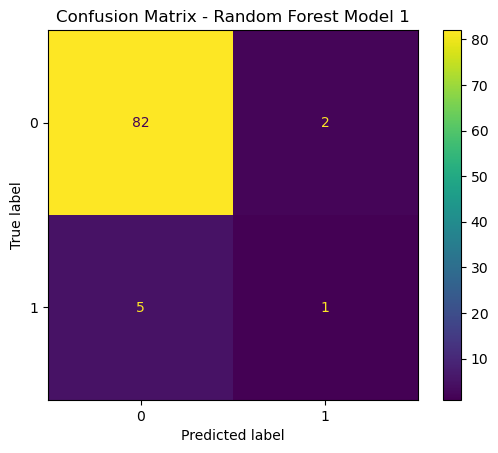

Model 1 likelihood of recession in Q4 2021: 0.00%


In [9]:
#Model 1 - lots of data, less variables. 2021Q4 Prediction.
# Ensure 'DATE' is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 1: Define training data to include all data up to Q4 2021
train_data = data[data['DATE'] < '2021-10-01'].copy()

# Create target variable
train_data['GDP_diff'] = train_data['GDP'].diff()
train_data['Recession'] = np.where(train_data['GDP_diff'] < 0, 1, 0)
train_data['Recession_next_quarter'] = train_data['Recession'].shift(-1)

# Define Model 1 variables
X_model1 = train_data[['CPATAX', 'PCECTPI', 'IPB50001SQ']]
y = train_data['Recession_next_quarter']

# Concatenate features and target, then drop rows with missing values
Xy_model1 = pd.concat([X_model1, y], axis=1).dropna()
X_model1_cleaned = Xy_model1.drop(columns=['Recession_next_quarter'])
y_model1_cleaned = Xy_model1['Recession_next_quarter']

# Scale features
scaler = StandardScaler()
X_model1_scaled = scaler.fit_transform(X_model1_cleaned)

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_model1_scaled, y_model1_cleaned, test_size=0.3, random_state=42, stratify=y_model1_cleaned)

# Define parameter grid for grid search
param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

# Pipeline for scaling and RandomForest
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Run GridSearchCV for Model 1 using accuracy as the metric
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=4), 
                             scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train1, y_train1)
print("Best parameters for Model 1:", grid_search.best_params_)
print("Best Accuracy score for Model 1:", grid_search.best_score_)

# Train the best model on the full training set
best_rf_model1 = grid_search.best_estimator_
best_rf_model1.fit(X_train1, y_train1)

# Evaluate the model
y_pred_model1 = best_rf_model1.predict(X_test1)
print("\nRandom Forest Model 1 Report (Test Set):\n", classification_report(y_test1, y_pred_model1, zero_division=0))
cm_model1 = confusion_matrix(y_test1, y_pred_model1)
ConfusionMatrixDisplay(confusion_matrix=cm_model1).plot()
plt.title("Confusion Matrix - Random Forest Model 1")
plt.show()

# Step 2: Prepare Q1 2022 data for prediction
# Include the last row from Q4 2021 to calculate differencing for Q1 2022
test_data_q4_2021 = data[(data['DATE'] >= '2021-07-01') & (data['DATE'] < '2021-10-01')].copy()
last_row_q4_2021 = test_data_q4_2021.iloc[-1]

# Step 3: Calculate differenced features for Q1 2022
X_test_model1_2022 = pd.DataFrame([{
    'CPATAX': data[data['DATE'] == '2021-10-01']['CPATAX'].values[0] - last_row_q4_2021['CPATAX'],
    'PCECTPI': data[data['DATE'] == '2021-10-01']['PCECTPI'].values[0] - last_row_q4_2021['PCECTPI'],
    'IPB50001SQ': data[data['DATE'] == '2021-10-01']['IPB50001SQ'].values[0] - last_row_q4_2021['IPB50001SQ']
}])

# Step 4: Scale the test features using the scaler from training
X_test_model1_scaled = scaler.transform(X_test_model1_2022)

# Step 5: Make predictions for Q1 2022
y_pred_proba_model1_Q1_2022 = best_rf_model1.predict_proba(X_test_model1_scaled)[:, 1]  # Probability of class 1 (recession)

# Print the percentage likelihood of a recession for Q1 2022
print(f"Model 1 likelihood of recession in Q4 2021: {y_pred_proba_model1_Q1_2022[0] * 100:.2f}%")


Best parameters for Model 3: {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Best Accuracy score for Model 3: 0.9375

Random Forest Model 3 Report (Test Set):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



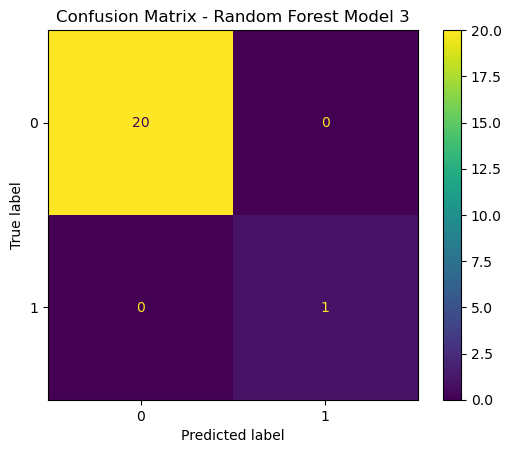

Prediction for recession in Q1 2022: 10.99% likelihood of recession


In [13]:
#Model 3 - less data, more novel variables 2021Q4 Prediciton.
# Ensure 'DATE' is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 1: Define training data to include all data up to Q4 2021
train_data = data[data['DATE'] < '2021-10-01'].copy()

# Create target variable and differenced features within the training set
train_data['GDP_diff'] = train_data['GDP'].diff()
train_data['Recession'] = np.where(train_data['GDP_diff'] < 0, 1, 0)
train_data['Recession_next_quarter'] = train_data['Recession'].shift(-1)

# Calculate differences for each variable
train_data['CPATAX_diff'] = train_data['CPATAX'].diff()
train_data['PCECTPI_diff'] = train_data['PCECTPI'].diff()
train_data['IPB50001SQ_diff'] = train_data['IPB50001SQ'].diff()
train_data['HOUST_diff'] = train_data['HOUST'].diff()
train_data['ADXDNO_diff'] = train_data['ADXDNO'].diff()
train_data['T10Y2Y_diff'] = train_data['T10Y2Y'].diff()
train_data['S&P 500_diff'] = train_data['S&P 500'].diff()
train_data['VIX_diff'] = train_data['VIX'].diff()
train_data['recession_diff'] = train_data['recession: (United States)'].diff()
train_data['unemployment_diff'] = train_data['Unemployment benefits: (United States)'].diff()
train_data['net_buys_diff'] = train_data['net_buys'].diff()

# Drop rows with NaN values after differencing
train_data.dropna(inplace=True)

# Model 3 feature set and target variable
X_model3 = train_data[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff', 'HOUST_diff', 'ADXDNO_diff', 
                       'T10Y2Y_diff', 'S&P 500_diff', 'VIX_diff', 'recession_diff', 'unemployment_diff', 'net_buys_diff']]
y_model3 = train_data['Recession_next_quarter']

# Scale features and split the data for Model 3
scaler = StandardScaler()
X_model3_scaled = scaler.fit_transform(X_model3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_model3_scaled, y_model3, test_size=0.3, random_state=42)

# Define parameter grid for grid search
param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

# Pipeline for scaling and RandomForest
pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])



# Run GridSearchCV for Model 3 with accuracy as the scoring metric
grid_search_3 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=4), 
                             scoring='accuracy', n_jobs=-1, verbose=0)
grid_search_3.fit(X_train3, y_train3)
print("Best parameters for Model 3:", grid_search_3.best_params_)
print("Best Accuracy score for Model 3:", grid_search_3.best_score_)


# Train the best model on the full training set for Model 3
best_rf_model3 = grid_search_3.best_estimator_
best_rf_model3.fit(X_train3, y_train3)
y_pred_model3 = best_rf_model3.predict(X_test3)

# Evaluate Model 3
print("\nRandom Forest Model 3 Report (Test Set):\n", classification_report(y_test3, y_pred_model3, zero_division=0))
cm_model3 = confusion_matrix(y_test3, y_pred_model3)
ConfusionMatrixDisplay(confusion_matrix=cm_model3).plot()
plt.title("Confusion Matrix - Random Forest Model 3")
plt.show()

# Step 2: Prepare Q1 2022 data for prediction
# Include the last row from Q4 2021 to calculate differencing for Q1 2022
test_data_2022_Q1 = data[(data['DATE'] >= '2021-07-01') & (data['DATE'] < '2022-01-01')].copy()

# Create differenced variables for Q1 2022 data
test_data_2022_Q1['CPATAX_diff'] = test_data_2022_Q1['CPATAX'].diff()
test_data_2022_Q1['PCECTPI_diff'] = test_data_2022_Q1['PCECTPI'].diff()
test_data_2022_Q1['IPB50001SQ_diff'] = test_data_2022_Q1['IPB50001SQ'].diff()
test_data_2022_Q1['HOUST_diff'] = test_data_2022_Q1['HOUST'].diff()
test_data_2022_Q1['ADXDNO_diff'] = test_data_2022_Q1['ADXDNO'].diff()
test_data_2022_Q1['T10Y2Y_diff'] = test_data_2022_Q1['T10Y2Y'].diff()
test_data_2022_Q1['S&P 500_diff'] = test_data_2022_Q1['S&P 500'].diff()
test_data_2022_Q1['VIX_diff'] = test_data_2022_Q1['VIX'].diff()
test_data_2022_Q1['recession_diff'] = test_data_2022_Q1['recession: (United States)'].diff()
test_data_2022_Q1['unemployment_diff'] = test_data_2022_Q1['Unemployment benefits: (United States)'].diff()
test_data_2022_Q1['net_buys_diff'] = test_data_2022_Q1['net_buys'].diff()

# Drop rows outside Q1 2022 to ensure we're predicting for Q4 2021 only
test_data_2022_Q1 = test_data_2022_Q1[test_data_2022_Q1['DATE'] >= '2021-10-01']
test_data_2022_Q1.dropna(inplace=True)

if not test_data_2022_Q1.empty:
    # Model 3 Prediction for Q1 2022
    X_test_model3_2022 = test_data_2022_Q1[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff', 'HOUST_diff', 'ADXDNO_diff', 
                                            'T10Y2Y_diff', 'S&P 500_diff', 'VIX_diff', 'recession_diff', 'unemployment_diff', 'net_buys_diff']]
    X_test_model3_scaled = scaler.transform(X_test_model3_2022)
    
    # Get probability predictions for Q1 2022
    y_pred_proba_model3_Q1_2022 = best_rf_model3.predict_proba(X_test_model3_scaled)[:, 1]  # Probability of class 1 (recession)
    
    # Print the percentage likelihood of a recession for each prediction
    for idx, prob in enumerate(y_pred_proba_model3_Q1_2022):
        print(f"Prediction for recession in Q1 2022: {prob * 100:.2f}% likelihood of recession")
else:
    print("No data available for Q1 2022 after differencing.")
